In [2]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from math import sqrt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# pip install matplotlib

In [5]:
# pip install sklearn

In [6]:
# pip install torchvision

In [7]:
# pip install pytorch_lightning

In [8]:
class imgsTortugas(Dataset):

    def __init__(self, ruta_imgs = '/datasets/imgs', 
                       ruta_labels = '/datasets/annotations',
                       transform = None):
        """
        
            Dentro de la función __init__ incluímos todo lo que queremos que pase cuando creamos el dataset,
            así cómo los argumentos con los que lo vamos a crear. En este caso, algunos argumentos los guardamos
            para usar más tarde, y además cargamos las anotaciones en un pandas dataframe

            Args:
                · ruta_imgs (string): directorio que contiene todos los archivos .jpeg con las imgs.
                · ruta_labels (string): directorio que contiene todos los archivos con las anotaciones (en .xml)
                · transform: una transformación o composición de transformaciones que se usarán para data augmentation
                
        """

        # Guardar ruta_imgs para usar más adelante
        self.ruta_imgs = ruta_imgs

        # Labels: tenemos que cargar los .xml y convertirlos en un dataframe. Para que quede más prolijo,
        # lo hacemos en una función aparte, en la próxima celda
        self.annotations_df = load_annotations(ruta_labels)
        self.ruta_etiquetas = ruta_labels

    def __len__(self):        
        return len(self.annotations_df)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Primero, extraemos, del dataframe con las anotaciones, las esquinas de la bounding box y las convertimos
        # en un tensor, que es el tipo de dato que usa pytorch en el entrenamiento de redes.
        row = self.annotations_df.loc[idx]
        bbox = torch.tensor(((row['x_min'],row['y_min']),(row['x_max'],row['y_max'])))

        # Cargar la imagen usando el nombre de archivo leido de la tabla con las anotaciones.
        labels_filename = os.path.split(self.annotations_df.filename[idx])[-1][:-4]
        img_filename = os.path.join(self.ruta_imgs, labels_filename + '.jpg')
        self.nombreimagen= labels_filename
    
        # Usamos el módulo Image de Pillow (PIL) para cargar la imagen
        img = Image.open(img_filename)

        # Luego extraemos los datos de pixel en un numpy array
        img_array = np.asarray(img)
        
        # Preprocesamiento:
        # -----------------
        # Este sería el punto donde aplicaríamos otras operaciones a la imagen. Por ahora,
        # lo único que vamos a dejar programado es convertir la imagen en un tensor.

        # 1) Convertir en un tensor
        img_array = torch.tensor(img_array, dtype = torch.float32)     
        
        
        # Finalmente, vamos a programar qué devuelve el dataset cuando le pedimos un elemento.
        # Por ahora, le vamos a pedir que devuelva lo mínimo que necesitamos para entrenar la red: los datos de pixel
        # y la posición de la bounding box
        
        sample = {'image': img_array, 'bbox': bbox}

        return sample

In [9]:
def load_annotations(path):

    """
    
        Esta función toma como entrada el directorio con todos los .xml con las anotaciones, y crea un pandas dataframe
        con los datos.
    
    """

    # Hacer una lista con todos los archivos en el directorio
    file_list = os.listdir(path)

    # Recorrer todos los archivos, y para cada archivo armar una fila del dataframe
    rows = []
    for file in file_list:

        # Generar una lista para ir armando la fila
        row = []

        # Unir la ruta con el nombre archivo
        file_path = os.path.join(path, file)
        extension = file_path[-3:]
        if extension == 'xml':
            # Guardar en la lista
            row.append(file_path)

            # Extraer la informacion de la bounding box del xml.

            root = ET.parse(file_path).getroot()
            polygon = root.find('./object/polygon')
            
            row.append(min( int(polygon[1].find('x').text), int(polygon[3].find('x').text)))
            row.append(max( int(polygon[1].find('x').text), int(polygon[3].find('x').text)))
            row.append(min( int(polygon[1].find('y').text), int(polygon[3].find('y').text)))
            row.append(max( int(polygon[1].find('y').text), int(polygon[3].find('y').text)))
            
            # Crear la nueva fila con estos datos
            rows.append(row)

    # Crear el dataframe
    df = pd.DataFrame(rows, columns = ['filename','x_min','x_max','y_min','y_max'])
    return df    

In [10]:
dataset_full = imgsTortugas(ruta_imgs = "datasets/imgs",
                            ruta_labels = "datasets/annotations")

# Los labels de los .xml ya deberían haberse cargado. Lo chequeamos:
dataset_full.annotations_df.shape

(992, 5)

In [11]:
def create_rect(bb, color='red'):
    """
    
        Crea un objeto matplotlib.patches.Rectangle a partir de las coordenadas de la bounding box.

        Args:
            · bb: coordenadas de las esquinas de la bounding box, en este formato:
            ((xmin,ymin),(xmax,ymax))

    """
    
    bb = bb.numpy()

    return plt.Rectangle((bb[0][0], bb[0][1]), bb[1][0] - bb[0][0], bb[1][1] - bb[0][1], color=color,
                         fill=False, lw=3)


def add_bb_to_axes(ax, bb, color='red'):
    """
    
        Toma un handler de una imagen pyplot (ax) y le agrega el bounding box indicado por las coordenadas bb

    """
    
    ax.add_patch(create_rect(bb, color = color))

def show_img_with_bb(im, bb, color='red'):
    """
    
    Muestra una imagen junto con su bounding box    

    """
    ax = plt.gca()
    plt.imshow(im)
    add_bb_to_axes(ax, bb, color)

Ajustes en el dataset

Definimos el modelo 

In [12]:
model = models.resnet18(pretrained = True)
model.fc = torch.nn.Linear(in_features = 512, out_features = 4, bias = True)

In [13]:
# Definir la función de pérdida
criterion = torch.nn.MSELoss()

In [14]:
# Elegimos un learning rate
lr = 0.001
bs=5

# Creamos el optimizador. Hay que pasarle, como parámetro de entrada, los parámetros de la red, que es lo que va a 
# intentar ajustar para minimizar la pérdida.
optimizer = optim.Adam(model.parameters(), lr = lr)

In [15]:
# pip install pytorch_lightning

Guardar el mejor modelo 

In [16]:
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n and fold: {fold}")
            torch.save({
                'epoch': epoch,
                'fold':fold,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': criterion
            },
                'outputs/best_model.pth')

In [17]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [18]:
# 80% de los datos para training
train_fraction = 0.7

# 10% para test (y los 10% que quedan son para evaluación)
test_fraction = 0.1

# Convertimos esos porcentajes a números (enteros)
train_size = int(train_fraction * len(dataset_full))
test_size = int(test_fraction * len(dataset_full))
eval_size = len(dataset_full) - train_size - test_size
#Armar indices para los sets
# Hacemos una lista de números del 0 al 999 (o al tamaño del dataset completo)
indices = np.arange(len(dataset_full))

# Mezclamos esa lista en forma aleatoria.
# La parte de RandomState(random_seed) se usa para controlar como es esa mezcla. random_seed es un número cualquiera (no importa el valor)
# que elegimos a mano. Lo importante es que, si no lo cambiamos, la mezcla siempre va a ser la misma. Esto nos permite generar siempre los
# mismos conjuntos de train, test y eval (si es que queremos eso). Si queremos diferentes conjuntos, cambiamos el valor de random_seed.
random_seed = 112
RandomState(random_seed).shuffle(indices)

# De la lista mezclada, extraemos los indices correspondiente a cada subconjunto.
indices_train = indices[0:train_size]
indices_test = indices[train_size:train_size + test_size]
indices_eval = indices[train_size + test_size:]

print(len(indices_train))
print(len(indices_test))
print(len(indices_eval))

694
99
199


In [19]:
# Configuration options
k_folds = 3
num_epochs = 50
torch.manual_seed(42)
kfold = KFold(n_splits=k_folds, shuffle=True)
    
# Start print
print('--------------------------------')
    
results = [] 
train_loss = [] 
eval_loss = [] 
loss_promedio_epoch = []
Outputs_lista = []

# initialize SaveBestModel class
save_best_model = SaveBestModel()

# lists to keep track of losses and accuracies
# train_loss, valid_loss = [], []


# K-fold Cross Validation model evaluation
for fold, (indices_train, indices_test) in enumerate(kfold.split(dataset_full)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    model.apply(weight_reset)
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(indices_train)
    test_subsampler = torch.utils.data.SubsetRandomSampler(indices_test)

    
    # Define data loaders for training and testing data in this fold
    trainloader = DataLoader(dataset_full, batch_size = bs , sampler=train_subsampler)
    testloader = DataLoader(dataset_full, batch_size=5,sampler=test_subsampler)
    
    # Creamos los dataloaders para cada subconjunto
    # Usar el dataloader para obtener un batch de imagenes
    iterador = iter(trainloader)
    batch = next(iterador)
    imgs = batch['image']
    # Intercambiamos de lugar las dimensiones 1 y 3
    imgs_permutadas = imgs.permute([0,3,2,1])
    
    # Initialize optimizer
    optimizer = optimizer
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        ### ----------- Entrenamiento -------------
        # Ponemos el modelo en modo entrenamiento
        model.train()
        
        # Definimos una variable para ir acumulando la pérdida obtenida en cada batch
        train_loss_epoch = 0
        eval_loss_epoch = 0
        loss_promedio_epoch = 0
        
        # Recorremos todos los batches que están en el dataloader de entrenamiento
        for index, batch in enumerate(trainloader):

                # Reseteamos los gradientes
                optimizer.zero_grad()

                # Extraemos las imagenes (data) y las posiciones de las bbox (target) del batch
                data = batch['image'].permute([0,3,2,1]) 
                target = batch['bbox']
                target = target.reshape([int(target.numel()/4),4]).type(torch.float)

                # Pasamos los datos por la red
                outputs = model(data)
                
                # Calculamos la pérdida
                loss = criterion(outputs, target)

                # Calculamos los gradientes
                loss.backward()

                # Actualizamos los parámetros de la red
                optimizer.step()

                # Registramos el valor de pérdida para poder mostrarlo más tarde
                train_loss_epoch +=  loss.item()

                # Una vez terminada la epoch, calculamos la pérdida promedio
                loss_avg_train = train_loss_epoch/(index + 1)
                
                # Convertir la lista en un numpy array
                train_loss_numpy = np.array(train_loss)
        
        # Una vez terminada la epoch, calculamos la pérdida promedio
        loss_avg_train = train_loss_epoch/(index + 1)
        print(f"Epoch: {epoch + 1}. Train loss: {loss_avg_train}")
        train_loss.append(loss_avg_train)
    
        ### ----------- Evaluacion -------------   
        # Desactivamos temporalmente el cálculo de gradientes
        with torch.no_grad():
            # Definimos una variable para ir acumulando la pérdida obtenida en cada batch
            test_loss_epoch = 0

            # Ponemos el modelo en modo evaluación
            model.eval()

            # Recorremos todos los batches que están en el dataloader de test        
            for index, batch in enumerate(testloader):
                # Extraemos las imagenes (data) y las posiciones de las bbox (target) del batch
                data = batch['image'].permute([0,3,2,1]) 
                target = batch['bbox']
                target = target.reshape([int(target.numel()/4),4]).type(torch.float)           

                outputs = model(data)

                # Calculamos la pérdida
                loss = criterion(outputs, target)

                # Registramos el valor de pérdida para poder mostrarlo más tarde
                eval_loss_epoch +=  loss.item()
                
                eval_loss_numpy = np.array(eval_loss)

        # Una vez terminada la epoch, calculamos la pérdida promedio
        loss_avg_eval = eval_loss_epoch/(index + 1)
        print(f"Epoch: {epoch + 1}. Eval loss: {loss_avg_eval}")  
        eval_loss.append(loss_avg_eval)
        valid_epoch_loss= loss_avg_eval
        
                
#         save_best_model(valid_epoch_loss, epoch, model, optimizer, criterion)
    
# save the loss and accuracy plots
# save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETED')

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Epoch: 1. Train loss: 7203.927741029209
Epoch: 1. Eval loss: 1615.1441486415579
Starting epoch 2
Epoch: 2. Train loss: 608.3643857052451
Epoch: 2. Eval loss: 705.060162672356
Starting epoch 3
Epoch: 3. Train loss: 364.91231092295254
Epoch: 3. Eval loss: 347.45594047432513
Starting epoch 4
Epoch: 4. Train loss: 338.33624253237156
Epoch: 4. Eval loss: 349.6605635685707
Starting epoch 5
Epoch: 5. Train loss: 321.1963820493311
Epoch: 5. Eval loss: 345.5879621363398
Starting epoch 6
Epoch: 6. Train loss: 319.75391066701786
Epoch: 6. Eval loss: 314.95201543551775
Starting epoch 7
Epoch: 7. Train loss: 278.5275519808432
Epoch: 7. Eval loss: 318.99259812084597
Starting epoch 8
Epoch: 8. Train loss: 256.0956687066788
Epoch: 8. Eval loss: 287.1145925948869
Starting epoch 9
Epoch: 9. Train loss: 211.49350021477034
Epoch: 9. Eval loss: 150.9940794759722
Starting epoch 10
Epoch: 10. Train loss: 186.24963499370

Epoch: 32. Eval loss: 55.87824402994185
Starting epoch 33
Epoch: 33. Train loss: 18.412578204520663
Epoch: 33. Eval loss: 47.398494805862654
Starting epoch 34
Epoch: 34. Train loss: 16.3895483465123
Epoch: 34. Eval loss: 66.64473230447342
Starting epoch 35
Epoch: 35. Train loss: 17.838595291725674
Epoch: 35. Eval loss: 57.547455517213734
Starting epoch 36
Epoch: 36. Train loss: 15.648832244084293
Epoch: 36. Eval loss: 84.83626906551532
Starting epoch 37
Epoch: 37. Train loss: 13.604451356973863
Epoch: 37. Eval loss: 61.66403192548609
Starting epoch 38
Epoch: 38. Train loss: 14.531641929669489
Epoch: 38. Eval loss: 49.376931332830175
Starting epoch 39
Epoch: 39. Train loss: 13.401637979019853
Epoch: 39. Eval loss: 44.16764889902144
Starting epoch 40
Epoch: 40. Train loss: 11.686059363802572
Epoch: 40. Eval loss: 64.7455538706993
Starting epoch 41
Epoch: 41. Train loss: 12.49922329680364
Epoch: 41. Eval loss: 42.25175918749909
Starting epoch 42
Epoch: 42. Train loss: 10.97175781888173
Ep

In [20]:
eval_loss_epoch

2419.354293823242

In [21]:
#CON ESTO VEO LOS TRAIN y EVAL LOSS
eval_loss
train_loss
epoch = []
for i in range(3):
    for x in range (50):
        epoch.append(x)

fold = []
for i in range(3):
    for x in range(50):
        fold.append(i)

test_df =  pd.DataFrame(list(zip(eval_loss, epoch,fold)),
               columns =['Test_loss', 'Epoch','Kfold'])
test_df.to_csv('test_df.csv', index= True)

train_df =  pd.DataFrame(list(zip(train_loss, epoch,fold)),
               columns =['Train_loss', 'Epoch','Kfold'])
train_df.to_csv('train_df.csv', index= True)

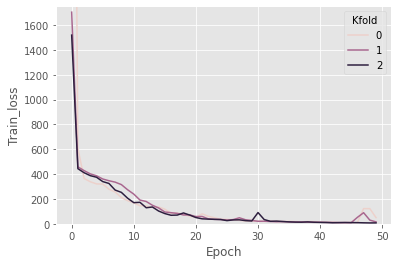

In [22]:
import seaborn as sns
lineplot1 =sns.lineplot(data=train_df, x="Epoch", y="Train_loss", hue="Kfold")
fig = lineplot1.get_figure()
# fig.savefig("Train_loss.png")

# control y limits
plt.ylim(0, 1750) 
plt.show()

<AxesSubplot:xlabel='Epoch', ylabel='Test_loss'>

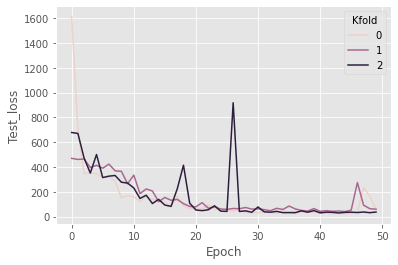

In [23]:
sns.lineplot(data=test_df, x="Epoch", y="Test_loss", hue="Kfold")

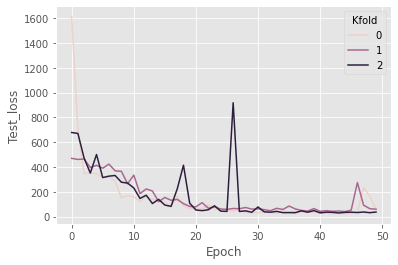

In [24]:
lineplot=sns.lineplot(data=test_df, x="Epoch", y="Test_loss", hue="Kfold")
fig = lineplot.get_figure()
# fig.savefig("Test_loss.png") 

# Evalúa el modelo en test 

The only difference here from the validation function is that we are not calculating the loss. Just the accuracy which we are returning at the end as well.

There are two other functions. One to test the best model and the other to test the last epoch saved model. These two functions will actually load the weights into the ResNet18 architecture from the checkpoints and call the above test() function.

# Pasamos por el mejor modelo

In [118]:
valid_subsampler = torch.utils.data.SubsetRandomSampler(indices_eval)
validloader = DataLoader(dataset_full, batch_size=5,sampler=valid_subsampler)

In [119]:
dataset_eval = torch.utils.data.Subset(dataset_full, indices_eval)

In [120]:
best_model = models.resnet18(pretrained = True)
best_model.fc = torch.nn.Linear(in_features = 512, out_features = 4, bias = True)


checkpoint = torch.load('outputs/best_model.pth')
best_model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## Intersection over union

In [121]:
## al tensor hay que llamarlo de distinta manera

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0:1,0], boxB[0:1,0])
    yA = max(boxA[0:1,1], boxB[0:1,1])
    xB = min(boxA[0:1,2], boxB[0:1,2])
    yB = min(boxA[0:1,3], boxB[0:1,3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[0:1,2] - boxA[0:1,0]) * (boxA[0:1,3] - boxA[0:1,1]))
    boxBArea = abs((boxB[0:1,2] - boxB[0:1,0]) * (boxB[0:1,3] - boxB[0:1,1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    iou_numpy = np.array(iou)

    # return the intersection over union value
    return iou_numpy

In [122]:
np.argsort(indices_eval)
indices_eval[0]

208

In [123]:
import random
random.Random(500).choice(indices_eval)

397

In [124]:
indices = np.arange(len(dataset_full))

# Mezclamos esa lista en forma aleatoria.
# La parte de RandomState(random_seed) se usa para controlar como es esa mezcla. random_seed es un número cualquiera (no importa el valor)
# que elegimos a mano. Lo importante es que, si no lo cambiamos, la mezcla siempre va a ser la misma. Esto nos permite generar siempre los
# mismos conjuntos de train, test y eval (si es que queremos eso). Si queremos diferentes conjuntos, cambiamos el valor de random_seed.
random_seed = 112
RandomState(random_seed).shuffle(indices)


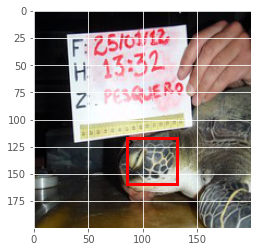

In [125]:
# Cambiar idx para ver diferentes imagenes
idx = 1
im = Image.fromarray(dataset_eval[idx]['image'].type(torch.uint8).numpy())
bb = dataset_eval[idx]['bbox']
show_img_with_bb(im, bb)

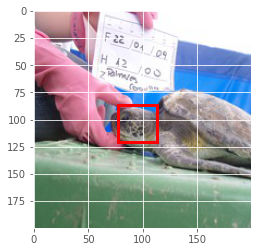

In [126]:
idx = 356
im = Image.fromarray(dataset_full[idx]['image'].type(torch.uint8).numpy())
bb = dataset_full[idx]['bbox']
show_img_with_bb(im, bb)

### Funciones de pérdida


In [127]:
# Mean Squared Error Loss Function
MSE = torch.nn.MSELoss()

#Mean absolute error
MAE= torch.nn.L1Loss()

#Kullback-Leibler Divergence Loss Function
divergence= torch.nn.KLDivLoss()

#Negative log likelihood loss with Poisson distribution of target. ????
poisson = nn.PoissonNLLLoss()

#Gaussian negative log likelihood loss.
gausian = nn.GaussianNLLLoss()
var = torch.ones(1, 4, requires_grad=True)

#In statistics, the Huber loss is a loss function used in robust regression, that is less sensitive
#to outliers in data than the squared error loss. 
huber = torch.nn.HuberLoss()

#SMOOTHL1LOSS
smoth = torch.nn.SmoothL1Loss(beta=1.0)

In [128]:
dataset_eval = torch.utils.data.Subset(dataset_full, indices_eval)

# Recorrer todo el dataset de evaluación
idx_list=[]
MSE_list=[]
RMSE_list = []
MAE_list=[]
divergence_list = []
poison_list = []
gausian_list = []
huber_list = []
smoth_list = []
iou_list=[]

for idx, element in enumerate(dataset_eval):

    # Extraer la imagen del dataset
    image = element['image']
    data = image.permute([2,1,0]).unsqueeze(0)

    bb_label = dataset_eval[idx]['bbox']
    target = bb_label.unsqueeze(0)
    target = target.reshape([int(target.numel()/4),4]).type(torch.float)  
    
    with torch.no_grad():
        # Pedirle a la red que calcule la bounding box para esa imagen    
        output = best_model(data)

        # Calcular funciones de pérdida
        loss1 = mean_squared_error(target, output)
        loss2 = mean_absolute_error(target, output)
        loss3 = divergence(output, target)
        loss4 = sqrt(mean_squared_error(target, output))
        loss5 = poisson(target, output)
        loss6 = gausian(target, output,var)
        loss7 = huber(target, output)
        loss8 = smoth(target, output)

        #iou
        iou= bb_intersection_over_union(target, output)
        iou= (str(iou).replace(' [', '').replace('[', '').replace(']', ''))
        

    MSE_list.append(loss1.item())
    MAE_list.append(loss2.item())
    RMSE_list.append(loss4.item())
    divergence_list.append(loss3.item())
    poison_list.append(loss5.item())
    gausian_list.append(loss6.item())
    huber_list.append(loss7.item())
    smoth_list.append(loss8.item())
    
    iou_list.append(iou)
    idx_list.append(idx)

NameError: name 'mean_squared_error' is not defined

In [ ]:
atributos = pd.DataFrame(
    {'index': indices_eval,
     'mean_squared_error': MSE_list,
     'mean_absolute_error': MAE_list,
     'root_mean_squared_error' :RMSE_list,
     'divergence': divergence_list,
     'gausian' : gausian_list,
     'huber' : huber_list,
     'smoth' : smoth_list,
     'iou': iou_list
    })
atributos

¿Cómo quedan las predicciones si ponemos threshold  50%, 75% or 95%.?

In [ ]:
atributos['iou'] = atributos['iou'].astype(float)

atributos['TP_50'] = np.where(atributos['iou'] >= 0.5, 1, 0)
atributos['TP_75'] = np.where(atributos['iou'] >= 0.75, 1, 0)
atributos['TP_95'] = np.where(atributos['iou'] >= 0.95, 1, 0)

#Armar esta lista con las decisiones que tomemos al mirar las fotos
atributos['TP_visual'] = np.arange(len(atributos))
atributos

In [ ]:
# Cambiar idx para ver diferentes imagenes
idx = 99
from matplotlib.pyplot import imshow
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
# Extraer la imagen y mostrarla
image = dataset_eval[idx]['image']
im = Image.fromarray(image.type(torch.uint8).numpy())
ax.imshow(im)
# Extraer la bounding box y agregarla a la imagen
bb_label = dataset_eval[idx]['bbox']
add_bb_to_axes(ax, bb_label, color = 'red')
# Calcular la bounding box que predice la red, y la pérdida asociada
with torch.no_grad():
    data = image.permute([2,1,0]).unsqueeze(0)
    target = bb_label.unsqueeze(0)
    target = target.reshape([int(target.numel()/4),4]).type(torch.float)
    output = best_model(data)
    # Dibujar la bounding box predicha a la imagen
    bb_inference = output.reshape([2,2])
    add_bb_to_axes(ax, bb_inference, color = 'blue')
    # Mostrar        
    ax.set_title(f"Index:{idx}", fontdict = {'fontsize':12})
plt.grid(None) 

Armo otro dataset para testear el árbol

In [ ]:
dataset_test = torch.utils.data.Subset(dataset_full, indices_test)

# Recorrer todo el dataset de evaluación
idx_list=[]
mean_squared_error_list=[]
mean_absolute_error_list=[]
divergence_list = []
gausian_list = []
huber_list = []
smoth_list = []
iou_list=[]

for idx, element in enumerate(dataset_test):

    # Extraer la imagen del dataset
    image = element['image']
    data = image.permute([2,1,0]).unsqueeze(0)

    bb_label = dataset_test[idx]['bbox']
    target = bb_label.unsqueeze(0)
    target = target.reshape([int(target.numel()/4),4]).type(torch.float)  
    
    with torch.no_grad():
        # Pedirle a la red que calcule la bounding box para esa imagen    
        output = best_model(data)

        # Calcular funciones de pérdida
        loss1 = mean_squared_error(target, output)
        loss2 = mean_absolute_error(target, output)
        loss3 = divergence(output, target)
        loss5 = poisson(target, output)
        loss6 = gausian(target, output,var)
        loss7 = huber(target, output)
        loss8 = smoth(target, output)

        #iou
        iou= bb_intersection_over_union(target, output)
        iou= (str(iou).replace(' [', '').replace('[', '').replace(']', ''))
        

    mean_squared_error_list.append(loss1.item())
    mean_absolute_error_list.append(loss2.item())
    divergence_list.append(loss3.item())
    poison_list.append(loss5.item())
    gausian_list.append(loss6.item())
    huber_list.append(loss7.item())
    smoth_list.append(loss8.item())
    
    iou_list.append(iou)
    idx_list.append(idx)

In [ ]:
atributos = pd.DataFrame(
    {'index': indices_eval,
     'mean_squared_error': mean_squared_error_list,
     'mean_absolute_error': mean_absolute_error_list,
     'divergence': divergence_list,
     'gausian' : gausian_list,
     'huber' : huber_list,
     'smoth' : smoth_list,
     'iou': iou_list
    })
atributos

In [ ]:
# Cambiar idx para ver diferentes imagenes
from matplotlib.pyplot import imshow
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
# Extraer la imagen y mostrara
idx = 1
image = dataset_test[idx]['image']
im = Image.fromarray(image.type(torch.uint8).numpy())
ax.imshow(im)
bb_label = dataset_test[idx]['bbox']
add_bb_to_axes(ax, bb_label, color = 'red')
with torch.no_grad():
    data = image.permute([2,1,0]).unsqueeze(0)
    target = bb_label.unsqueeze(0)
    target = target.reshape([int(target.numel()/4),4]).type(torch.float)
    output = best_model(data)
    bb_inference = output.reshape([2,2])
    add_bb_to_axes(ax, bb_inference, color = 'blue')
    ax.set_title(f"Index:{idx}", fontdict = {'fontsize':12})
plt.grid(None) 

Calcular métricas del detector: 
Precision x Recall curve y Average Precision

¿Hay métricas que indiquen calidad de foto? ¿proporcion de oscuridad? ¿?